# Bayesian Delegation Algorithm

Based on paper *Too many cooks: Bayesian inference for coordinating multi-agent collaboration*

- Author: Kaixin Wang
- Date: Fall 2020 Week 6

Plan for Week 6:

1. Modify the `merge()` function to a class of functions
2. unittest the function
3. continue setting up the environment

**Library Imports and Graphical Setups**

In [1]:
import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Part I: Enviroment Setups

### 1. Environment Grid

In [2]:
def createEnvironment(objects, xmax = 7, ymax = 7):#, goal = (0,3)):
    xrange = range(0,xmax); yrange = range(0,ymax)
    coordinates = [(x,y) for x in xrange for y in yrange]
    possibleStatus = {"Agent":[], "Plate":[], "Counter":[], "Delivery":[], "Knife":None, 
                      "Tomato":["chopped", "unchopped"], "Lettuce":["chopped", "unchopped"]}
    S = {s:{"type":None, "status":[]} for s in coordinates}
    for key, obj in objects.items():
        for pair in obj:
            S[pair]["type"] = key
            if key in ["Tomato", "Lettuce"]:
                S[pair]["status"] = "unchopped"
    return S

In [3]:
objects = {"Counter":[(0,0), (0,1), (0,2), (0,4), (0,5), (0,6),
                      (1,6), (2,6), (3,6), (4,6), (5,6), (6,6),
                      (6,5), (6,4), (6,3), (6,2), (6,1), (6,0),
                      (5,0), (4,0), (3,0), (2,0), (1,0)],
           "Goal":[(0,3)], "Knife":[(0,4), (0,5)], "Plate":[(5,0), (6,1)],
           "Lettuce":[(6,5)], "Tomato":[(5,6)], "Agent":[(2,5), (4,5)],}
S = createEnvironment(objects)
S

{(0, 0): {'type': 'Counter', 'status': []},
 (0, 1): {'type': 'Counter', 'status': []},
 (0, 2): {'type': 'Counter', 'status': []},
 (0, 3): {'type': 'Goal', 'status': []},
 (0, 4): {'type': 'Knife', 'status': []},
 (0, 5): {'type': 'Knife', 'status': []},
 (0, 6): {'type': 'Counter', 'status': []},
 (1, 0): {'type': 'Counter', 'status': []},
 (1, 1): {'type': None, 'status': []},
 (1, 2): {'type': None, 'status': []},
 (1, 3): {'type': None, 'status': []},
 (1, 4): {'type': None, 'status': []},
 (1, 5): {'type': None, 'status': []},
 (1, 6): {'type': 'Counter', 'status': []},
 (2, 0): {'type': 'Counter', 'status': []},
 (2, 1): {'type': None, 'status': []},
 (2, 2): {'type': None, 'status': []},
 (2, 3): {'type': None, 'status': []},
 (2, 4): {'type': None, 'status': []},
 (2, 5): {'type': 'Agent', 'status': []},
 (2, 6): {'type': 'Counter', 'status': []},
 (3, 0): {'type': 'Counter', 'status': []},
 (3, 1): {'type': None, 'status': []},
 (3, 2): {'type': None, 'status': []},
 (3, 3):

### 2. State Space

In [4]:
states = {"Agent":{'1':{'Location':(0,0), 'Status': None}, '2':{'Location':(1,2), 'Status':None}}, 
          "Plate":[], "Counter":[], "Delivery":[], "Knife":None, 
          "Tomato":["chopped", "unchopped"], "Lettuce":["chopped", "unchopped"]}
states

{'Agent': {'1': {'Location': (0, 0), 'Status': None},
  '2': {'Location': (1, 2), 'Status': None}},
 'Plate': [],
 'Counter': [],
 'Delivery': [],
 'Knife': None,
 'Tomato': ['chopped', 'unchopped'],
 'Lettuce': ['chopped', 'unchopped']}

### 3. Action Space

 - four cardinal direction

### 4. Transition Function

- movement rules (no collision - with each other, counters, etc.)
- Food interaction (Merge(X,Y) for food + knife = unchopped -> chopped)
- Pick up object (Merge(X,Y) for agent + moveable object = hold)
- Combine foods (Merge(X,y) for food1, food2 = food1+food2
- Plate food (Merge(X,Y) for food +plate = plated food
- Deliver food (Merge(X,Y) for objective food + star location = deliver

In [5]:
blocks = []
for xy in objects.values():
    for pair in xy:
        if pair not in blocks:
            blocks.append(pair)

In [6]:
def transitionFull(s, move, minX, minY, maxX, maxY, blockList):
    x, y=s
    dx, dy=move
    def boundary(x, minX, maxX):
        return max(minX, min(x, maxX))
    sPrimeConsideringBoundary=(boundary(x+dx, minX, maxX), boundary(y+dy, minY, maxY))
    def blocking(sPrime, blockList):
        if sPrime in blockList:
            return s
        else:
            return sPrime
    sPrime=blocking(sPrimeConsideringBoundary, blockList)
    return sPrime

def createTransitionTable(minX, minY, maxX, maxY, blockList, possibleAction, transitionProbability):
    possibleState=[(i,j) for i in range(minX, maxX+1) for j in range(minY, maxY+1)]
    for block in blockList:
        possibleState.remove(block)
        
    moves={'forward':{(1,0):(1,0),(0,-1):(0,-1),(-1,0):(-1,0),(0,1):(0,1)},\
           'left':{(1,0):(0,-1),(0,-1):(-1,0),(-1,0):(0,1),(0,1):(1,0)},\
           'right':{(1,0):(0,1),(0,-1):(1,0),(-1,0):(0,-1),(0,1):(-1,0)},\
           'back':{(1,0):(-1,0),(0,-1):(0,1),(-1,0):(1,0),(0,1):(0,-1)}}
    
    def transition(s, move):
        return transitionFull(s, move, minX, minY, maxX, maxY, blockList)
    
    def transitionFunction(s, action, sPrime, transitionProbability, moves):
        moveDictionary={moves[move][action]:transitionProbability[move] for move in transitionProbability.keys()}
        sPrimeProbability=sum([p for move, p in moveDictionary.items() if transition(s, move)==sPrime])
        return sPrimeProbability
    
    emptyTransitionTable={s:{action:{transition(s, moves[move][action]):transitionProbability[move] 
                                     for move in transitionProbability.keys()} 
                             for action in possibleAction} 
                          for s in possibleState}
    
    transitionTable={s:{action:{sPrime:transitionFunction(s, action, sPrime, transitionProbability, moves) 
                                for sPrime in emptyTransitionTable[s][action].keys()} 
                        for action in possibleAction} 
                     for s in possibleState}
    return transitionTable

In [7]:
p=1
possibleAction=[(0,1), (0,-1), (1,0), (-1,0)]
# probablistic transition
# transitionProbability={'forward':p/4, 'left':p/4, 'right':p/4, 'back':p/4}
# deterministic transition
transitionProbability={'forward':p, 'left':(1-p)/2, 'right':(1-p)/2, 'back':0}
transitionProbability={move: p for move, p in transitionProbability.items() if transitionProbability[move]!=0}
transitionTable=createTransitionTable(0, 0, 6, 6, blocks, possibleAction, transitionProbability)

In [8]:
transitionTable

{(1, 1): {(0, 1): {(1, 2): 1},
  (0, -1): {(1, 1): 1},
  (1, 0): {(2, 1): 1},
  (-1, 0): {(1, 1): 1}},
 (1, 2): {(0, 1): {(1, 3): 1},
  (0, -1): {(1, 1): 1},
  (1, 0): {(2, 2): 1},
  (-1, 0): {(1, 2): 1}},
 (1, 3): {(0, 1): {(1, 4): 1},
  (0, -1): {(1, 2): 1},
  (1, 0): {(2, 3): 1},
  (-1, 0): {(1, 3): 1}},
 (1, 4): {(0, 1): {(1, 5): 1},
  (0, -1): {(1, 3): 1},
  (1, 0): {(2, 4): 1},
  (-1, 0): {(1, 4): 1}},
 (1, 5): {(0, 1): {(1, 5): 1},
  (0, -1): {(1, 4): 1},
  (1, 0): {(1, 5): 1},
  (-1, 0): {(1, 5): 1}},
 (2, 1): {(0, 1): {(2, 2): 1},
  (0, -1): {(2, 1): 1},
  (1, 0): {(3, 1): 1},
  (-1, 0): {(1, 1): 1}},
 (2, 2): {(0, 1): {(2, 3): 1},
  (0, -1): {(2, 1): 1},
  (1, 0): {(3, 2): 1},
  (-1, 0): {(1, 2): 1}},
 (2, 3): {(0, 1): {(2, 4): 1},
  (0, -1): {(2, 2): 1},
  (1, 0): {(3, 3): 1},
  (-1, 0): {(1, 3): 1}},
 (2, 4): {(0, 1): {(2, 4): 1},
  (0, -1): {(2, 3): 1},
  (1, 0): {(3, 4): 1},
  (-1, 0): {(1, 4): 1}},
 (3, 1): {(0, 1): {(3, 2): 1},
  (0, -1): {(3, 1): 1},
  (1, 0): {(4, 1):

### 5. Subtask Space

- define the set of ta = Merge(item1, item2) for all items - see figure 5 for salad recipe
- to chop food, must be unchopped
- to plate food, must be chopped
- to deliver, must follow recipe

The kitchens are built from counters that contain both __movable__ food and plates and __immovable__ stations (e.g. knife stations). The state is represented as a list of entities and their type, location, and status

### Class `MergeAgentItem`

In [9]:
from MergeAgentItem import MergeAgentItem

In [10]:
recipe = [["Tomato.chopped.plated"], ["Lettuce.chopped.plated"]]
merge = MergeAgentItem(recipe)

**Possible ways to deliver food**:

1. ["pick up food", "go to knife station", "pick up the plate", "go to knife station", "plate the food", "deliver"]
2. ["pick up food", "pick up the plate", "go to knife station", "chop the food", "deliver"]
3. ["pick up plate", "pick up the food", "go to knife station", "deliver"]

#### Example 1: 

Step 1: Deliver lettuce via method 2

In [11]:
S = createEnvironment(objects)
x = (4,5); y = (6,5)
merge(S, x, y)

x: Agent y: Lettuce
x: [] y: unchopped
1.1 pick up the food
x: Agent y: Counter
x: Lettuce.unchopped y: []


In [12]:
x = (4,5); y = (6,5)
merge(S, x, y)

x: Agent y: Counter
x: Lettuce.unchopped y: []
x: Agent y: Counter
x: Lettuce.unchopped y: []


In [13]:
x = (4,5); y = (0, 4)
merge(S, x, y)

x: Agent y: Knife
x: Lettuce.unchopped y: []
2. chop the food
x: Agent y: Knife
x: [] y: ['Lettuce.chopped']


In [14]:
x = (4,5); y = (0, 5)
merge(S, x, y)

x: Agent y: Knife
x: [] y: []
x: Agent y: Knife
x: [] y: []


In [15]:
x = (4,5); y = (0, 4)
merge(S, x, y)

x: Agent y: Knife
x: [] y: ['Lettuce.chopped']
x: Agent y: Knife
x: [] y: ['Lettuce.chopped']


In [16]:
x = (4,5); y = (6,1)
merge(S, x, y)

x: Agent y: Plate
x: [] y: []
3. pick up the plate
x: Agent y: Counter
x: Plate y: []


In [17]:
x = (4,5); y = (0, 3)
merge(S, x, y)

x: Agent y: Goal
x: Plate y: []
x: Agent y: Goal
x: Plate y: []


Step 2: deliver tomato using method 3

In [18]:
x = (4,5); y = (6,0)
merge(S, x, y)

x: Agent y: Counter
x: Plate y: []
x: Agent y: Counter
x: Plate y: []


In [19]:
x = (4,5); y = (6,1)
merge(S, x, y)

x: Agent y: Counter
x: Plate y: []
x: Agent y: Counter
x: Plate y: []


In [20]:
x = (4,5); y = (5,6)
merge(S, x, y)

x: Agent y: Tomato
x: Plate y: unchopped
1.2 pick up the food and plate it
x: Agent y: Counter
x: Tomato.unchopped.plated y: []


In [21]:
x = (4,5); y = (0, 3)
merge(S, x, y)

x: Agent y: Goal
x: Tomato.unchopped.plated y: []
x: Agent y: Goal
x: Tomato.unchopped.plated y: []


In [22]:
x = (4,5); y = (0, 5)
merge(S, x, y)

x: Agent y: Knife
x: Tomato.unchopped.plated y: []
7. chop plated raw food
7.1 out for delivery
x: Agent y: Knife
x: Tomato.chopped.plated.delivery y: []


In [23]:
x = (4,5); y = (0, 3)
merge(S, x, y)

x: Agent y: Goal
x: Tomato.chopped.plated.delivery y: []
5. delivered the food
delivered = 1
x: Agent y: Goal
x: [] y: ['Tomato.chopped.plated.delivery']


#### Example 2: delivery via method 1

In [24]:
S = createEnvironment(objects)
x = (4,5); y = (5,6)
merge(S, x, y)

x: Agent y: Tomato
x: [] y: unchopped
1.1 pick up the food
x: Agent y: Counter
x: Tomato.unchopped y: []


In [25]:
x = (4,5); y = (0,4)
merge(S, x, y)

x: Agent y: Knife
x: Tomato.unchopped y: []
2. chop the food
x: Agent y: Knife
x: [] y: ['Tomato.chopped']


In [26]:
x = (4,5); y = (5,0)
merge(S, x, y)

x: Agent y: Plate
x: [] y: []
3. pick up the plate
x: Agent y: Counter
x: Plate y: []


In [27]:
x = (4,5); y = (0,4)
merge(S, x, y)

x: Agent y: Knife
x: Plate y: ['Tomato.chopped']
4. plate the food
4.1 out for delivery
x: Agent y: Knife
x: Tomato.chopped.plated.delivery y: []


In [28]:
x = (4,5); y = (0,3)
merge(S, x, y)

x: Agent y: Goal
x: Tomato.chopped.plated.delivery y: []
5. delivered the food
delivered = 2
x: Agent y: Goal
x: [] y: ['Tomato.chopped.plated.delivery']


In [29]:
x = (4,5); y = (6,5)
merge(S, x, y)

x: Agent y: Lettuce
x: [] y: unchopped
1.1 pick up the food
x: Agent y: Counter
x: Lettuce.unchopped y: []


In [30]:
x = (4,5); y = (0,4)
merge(S, x, y)

x: Agent y: Knife
x: Lettuce.unchopped y: []
2. chop the food
x: Agent y: Knife
x: [] y: ['Lettuce.chopped']


In [31]:
x = (4,5); y = (0,3)
merge(S, x, y)

x: Agent y: Goal
x: [] y: ['Tomato.chopped.plated.delivery']
x: Agent y: Goal
x: [] y: ['Tomato.chopped.plated.delivery']


In [32]:
x = (4,5); y = (6,1)
merge(S, x, y)

x: Agent y: Plate
x: [] y: []
3. pick up the plate
x: Agent y: Counter
x: Plate y: []


In [33]:
x = (4,5); y = (0, 5)
merge(S, x, y)

x: Agent y: Knife
x: Plate y: []
x: Agent y: Knife
x: Plate y: []


In [34]:
x = (4,5); y = (0, 4)
merge(S, x, y)

x: Agent y: Knife
x: Plate y: ['Lettuce.chopped']
4. plate the food
4.1 out for delivery
x: Agent y: Knife
x: Lettuce.chopped.plated.delivery y: []


In [35]:
x = (4,5); y = (0, 2)
merge(S, x, y)

x: Agent y: Counter
x: Lettuce.chopped.plated.delivery y: []
x: Agent y: Counter
x: Lettuce.chopped.plated.delivery y: []


In [36]:
x = (4,5); y = (0, 3)
merge(S, x, y)

x: Agent y: Goal
x: Lettuce.chopped.plated.delivery y: ['Tomato.chopped.plated.delivery']
5. delivered the food
delivered = 3
finished all deliveries
x: Agent y: Goal
x: [] y: ['Tomato.chopped.plated.delivery', 'Lettuce.chopped.plated.delivery']


### Visualization of the environment

In [37]:
S = createEnvironment(objects)

In [38]:
def plotS(S, xmin = 0, xmax = 6+1, ymin = 0, ymax = 6+1):
    '''Function to display the current environment'''
    sns.set(style = "ticks")
    plt.figure(figsize = (6,6), dpi=80)
    plt.plot([xmin-0.5, xmax-0.5, xmax-0.5, xmin-0.5, xmin-0.5], # #1f77b4
             [ymin-0.5, ymin-0.5, ymax-0.5, 7-0.5, ymax-0.5], color = "lightgray")
    for i in range(1,xmax):
        plt.plot([0-0.5, 7-0.5], [i-0.5, i-0.5], color = "lightgray")
        plt.plot([i-0.5, i-0.5], [ymin-0.5, ymax-0.5], color = "lightgray")
    plt.xlim([xmin-0.5,xmax-0.5]);plt.ylim([ymin-0.5,ymax-0.5])
    colors = {"Counter":"black", "Agent":"darkgreen", "Knife":"blue", "Plate":"red", 
              "Lettuce":"orange", "Tomato":"orange", "Goal":"gold",  None:None}
    for location in S.keys():
        plt.text(location[0]-0.42, location[1], S[location]["type"], color = colors[S[location]["type"]])
    plt.show()

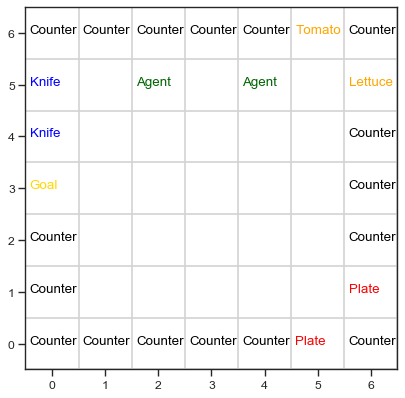

In [39]:
plotS(S)

## Part II: Bounded Real-Time Dynamic Programming (BRTDP)

In [40]:
def BRTDP(s, ta, T, A):
    '''
    Inputs: s, ta, T, A
    Outputs: V, Q, pi(policy)
    '''
    return 0

## Part III: Level-K Hierarchy

In [41]:
def levelK():
    return 0

## Part IV: Bayesian Delegation

### Subtask space

In [42]:
ta0 = {"Tomato":["pick", "chop", "plate", "deliver"],
      "Lettuce":["pick", "chop", "plate", "deliver"]}
ta = []
for food, actions in ta0.items():
    for action in actions:
        ta.append(food + "." + action)
ta = {task:1/len(ta) for task in ta}
ta

{'Tomato.pick': 0.125,
 'Tomato.chop': 0.125,
 'Tomato.plate': 0.125,
 'Tomato.deliver': 0.125,
 'Lettuce.pick': 0.125,
 'Lettuce.chop': 0.125,
 'Lettuce.plate': 0.125,
 'Lettuce.deliver': 0.125}

### Set of helper functions

In [43]:
def getNextState(state, action):
    '''
    - location
    - item status change
    '''
    #return(stateNext)
    return 0

In [44]:
def implementCooperativeJointPolicy():
    pass

In [45]:
def resetSubtaskPrior(state, getValue):
    pass
#return P(ta) as a PDF

In [46]:
def getActionLikelihood():
    pass # equation 2

### Bayesian Delegation

In [47]:
# main Bayesian Delegation shown in Appendix B


## Appendix

### A Notation

- cursive T: list of subtasks
- **ta**: delegation of subtasks
- ta: one delegation from **ta**

### B Pseudocode for Bayesian Delegation Algorithm

![Pseudocode for Bayesian Delegation Algorithm](BDAlgorithm.png)

&copy; Updated by Kaixin Wang, Week 6 Fall 2020